# Titanic: Machine Learning from Disaster

In [2]:
# https://www.kaggle.com/c/titanic

In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [3]:
train_dummies = pd.get_dummies(train, columns=['Sex', 'Pclass', 'Embarked'])
test_dummies = pd.get_dummies(test, columns=['Sex', 'Pclass', 'Embarked'])

## Preprocess data

In [4]:
# Extract features
X_train = train_dummies.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
X_test = test_dummies.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [5]:
# Extract targets
y_train = train_dummies['Survived']

In [6]:
# Fill NA values
from sklearn.preprocessing import Imputer
imp_x = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=True)
imp_x.fit(X_train)
col = list(X_train)
X_train = pd.DataFrame(data=imp_x.transform(X_train), columns=col)
X_test = pd.DataFrame(data=imp_x.transform(X_test), columns=col)

In [7]:
# Scale features
# Scale features

from sklearn.preprocessing import StandardScaler
StandardScaler(copy=False, with_mean=True, with_std=True)
ss = StandardScaler()
ss.fit(X_train)
X_train = pd.DataFrame(data=ss.transform(X_train), columns=col)
X_test = pd.DataFrame(data=ss.transform(X_test), columns=col)

## Train model and make predictions

### Упражняемся с логистической регрессией

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {'class_weight': [{0:1, 1:1}, 'balanced']}

grid = GridSearchCV(LogisticRegressionCV(), param_grid)

grid.fit(X_train, y_train)

model = grid.best_estimator_

y_predicted =model.predict(X_train)

print('model accuracy', accuracy_score(y_train, y_predicted, normalize=True, sample_weight=None))
print(model.C_) #=> 0.04641589
print(model.class_weight) #=> {0: 1, 1: 1} - выигрывает несбалансированная модель

model accuracy 0.803591470258
[ 0.04641589]
{0: 1, 1: 1}


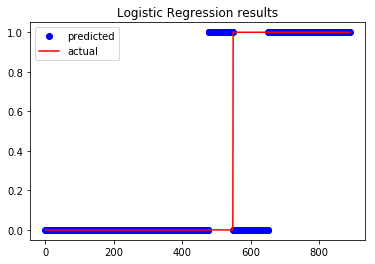

In [9]:
pairs = np.array(sorted(zip(y_train, y_predicted)))
plt.plot(range(0, len(pairs)), pairs[:, 1], 'bo',
         range(0, len(pairs)), pairs[:, 0], 'r-')

plt.legend(['predicted', 'actual'])
plt.title('Logistic Regression results')
plt.show()

Перебор различных моделей

model accuracy 0.902356902357
Pipeline(steps=[('model', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))])


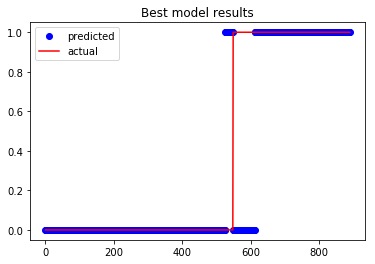

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

pipeline = Pipeline(steps=[('model', LogisticRegression(C=0.04641589))])

param_grid = {'model': [GradientBoostingClassifier(),
                        RandomForestClassifier(),
                        BaggingClassifier()]}

scorer = make_scorer(accuracy_score)

grid = GridSearchCV(pipeline, param_grid, scorer, cv=4)

grid.fit(X_train, y_train)

model = grid.best_estimator_

y_best_prediction = model.predict(X_train)

print('model accuracy', accuracy_score(y_train, y_best_prediction, normalize=True, sample_weight=None))
print(grid.best_estimator_) # =>  GradientBoostingClassifier

pairs = np.array(sorted(zip(y_train, y_best_prediction)))
plt.plot(range(0, len(pairs)), pairs[:, 1], 'bo',
         range(0, len(pairs)), pairs[:, 0], 'r-')

plt.legend(['predicted', 'actual'])
plt.title('Best model results')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'join'

In [100]:
#from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

#kf = KFold(n_splits=4, shuffle=True)
pipeline = Pipeline(steps=[('model', GradientBoostingClassifier())])
param_grid = {'model__learning_rate': list(np.logspace(-3, 0, 20)), 'model__n_estimators': np.linspace(10, 100, 10, dtype='int64')}
scorer = make_scorer(accuracy_score)

grid = GridSearchCV(pipeline, param_grid, cv=4, scoring=scorer)

grid.fit(X_train, y_train)

best_params = grid.best_params_

model = GradientBoostingClassifier(
          learning_rate=best_params['model__learning_rate'],
          n_estimators=best_params['model__n_estimators']
        )

model.fit(X_train, y_train)

y_best_prediction = model.predict(X_train)

print('model accuracy', accuracy_score(y_train, y_best_prediction, normalize=True, sample_weight=None))

model accuracy 0.90684624018


In [90]:
best_params = grid.best_params_
best_params

{'model__learning_rate': 0.23357214690901212, 'model__n_estimators': 50}

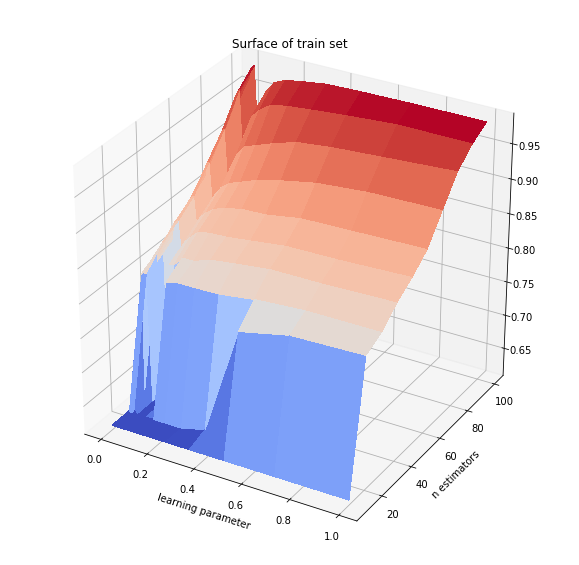

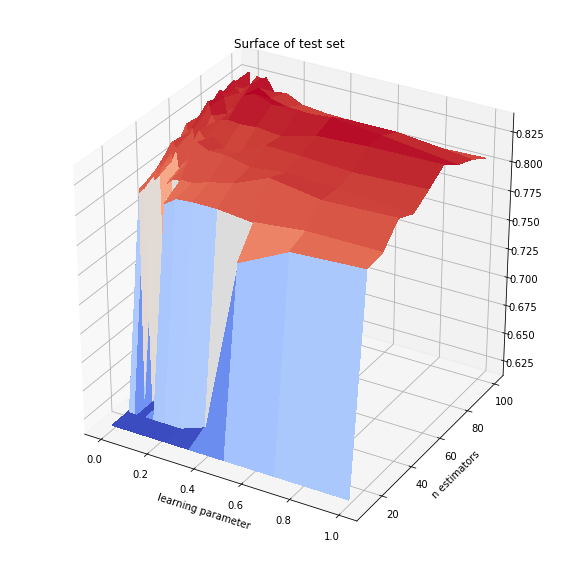

In [78]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

zs_train = grid.cv_results_['mean_train_score'].reshape(10,20)
zs_test = grid.cv_results_['mean_test_score'].reshape(10,20)
xs = np.logspace(-3, 0, 20)
ys = np.linspace(10, 100, 10, dtype='int64')

xs, ys = np.meshgrid(xs, ys)

fig = plt.figure(1, figsize=(10,10));
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xs, ys, zs_train, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.title('Surface of train set')
ax.set_xlabel('learning parameter')
ax.set_ylabel('n estimators')
plt.show();

fig2 = plt.figure(2, figsize=(10,10))

ax = fig2.gca(projection='3d')

surf = ax.plot_surface(xs, ys, zs_test, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.title('Surface of test set')
ax.set_xlabel('learning parameter')
ax.set_ylabel('n estimators')
plt.show();


Лучшее значение на тестовой выборке

In [80]:
grid.cv_results_['mean_test_score'].max()

0.83613916947250277

Из приведенных графиков видно, что на тестовых подвыборках точность модели ведет себя более сложным образом - точность модели на тестовой выборке падает с увеличением с параметра n_estimators (переобучение?)

In [94]:
# Estimate model quality using cross-validation
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#


kf = KFold(n_splits=4, shuffle=True)
print(cross_val_score(
    GradientBoostingClassifier(
        learning_rate=best_params['model__learning_rate'],
        n_estimators=best_params['model__n_estimators']
    ),
    X_train, y_train, cv=kf)\
    .mean()
     )

0.828283440391


## Create submission 

In [101]:
test_predicted = model.predict(X_test)

with open('submission_.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], test_predicted):
        out.write('%s,%s\n' % (passenger, y))

По неведомой причине на Kaggle score == 0.75120

In [103]:
model_basic = GradientBoostingClassifier()
model_basic.fit(X_train, y_train)
test_predicted_basic = model_basic.predict(X_test)

with open('submission_basic.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], test_predicted_basic):
        out.write('%s,%s\n' % (passenger, y))

Точность базовой модели на Kaggle == 0.77990

In [104]:
# Estimate model quality using cross-validation
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#


kf = KFold(n_splits=4, shuffle=True)
print(cross_val_score(
    GradientBoostingClassifier(
    ),
    X_train, y_train, cv=kf)\
    .mean()
     )

0.828273340605


Кросс-валидация на базовой модели практически такая же, как и на оптимизорованной модели